In [20]:
import keras.wrappers.scikit_learn
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV#, train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Packages.load_data import load_csv, save_model, train_test, train_test_valid
from Packages.nn import build_model
from sklearn.model_selection import train_test_split

In [6]:
file = './data/abalone_data.csv'
column_names = ['Sex', 'Length_mm', 'Diameter_mm', 'Height_mm', 'Whole_weight_gms',
                'Shucked_weight_gms', 'Viscera_weight_gms', 'Shell_weight_gms', 'Rings']

raw = pd.read_csv(file, names=column_names)

data = load_csv()
df = data.copy()
orig = data.copy()
# remove 2 outliers from 'Height_mm'
df = df[df['Height_mm'] < 0.4]

From original csv, added 'Age', 'AgeClass', and changed 'Sex' to category


In [7]:
continuous = ['Length_mm', 'Diameter_mm', 'Height_mm', 'Whole_weight_gms', 'Shucked_weight_gms', 'Viscera_weight_gms', 'Shell_weight_gms']

for col in continuous:
    orig[col] = orig[col] * 200

In [8]:
raw.shape, data.shape, df.shape, orig.shape

((4177, 9), (4177, 11), (4175, 11), (4177, 11))

# Train Test Split

## Stratified Split

In [ ]:
"""
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)

for train_index, test_index in split.split(df, df['AgeClass']):
    strat_train = df.loc[train_index]
    strat_test = df.loc[test_index]
    
# print(strat_test['AgeClass'].value_counts() / len(strat_test))
print(strat_test['AgeClass'].value_counts())
# print(strat_train['AgeClass'].value_counts() / len(strat_train))
print(strat_train['AgeClass'].value_counts())
# print(df['AgeClass'].value_counts() / len(df))
"""

In [ ]:
"""
X_train = strat_train.drop(['Sex', 'Rings', 'Age', 'AgeClass'], axis=1)
y_train = strat_train['AgeClass']
y_train = pd.get_dummies(y_train)
X_test = strat_test.drop(['Sex', 'Rings', 'Age', 'AgeClass'], axis=1);
y_test = strat_test['AgeClass']
y_test = pd.get_dummies(y_test)
"""

In [ ]:
# X_test, y_test

In [ ]:
"""
X = df.drop(['Sex', 'Rings', 'Age', 'AgeClass'], axis=1)
y = df['AgeClass']
#X = df.drop(['Rings', 'Age', 'AgeClass'], axis=1)
#X = np.array(X)
# if using 'categorical_crossentropy' loss, then labels in one_hot representation
y = pd.get_dummies(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)  # stratify=y,  
"""

## Use Train, Test, Valid

In [9]:
X = df.drop(['Sex', 'Rings', 'Age', 'AgeClass'], axis=1)
y = df['AgeClass']
# if using 'categorical_crossentropy' loss, then labels in one_hot representation
y = pd.get_dummies(y)
X_train, X_test, X_valid, y_train, y_test, y_valid = train_test_valid(X, y)

In [10]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape, type(X_test), type(y_test)

((2004, 7),
 (2004, 4),
 (501, 7),
 (501, 4),
 (1670, 7),
 (1670, 4),
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame)

### Scaling

In [ ]:
"""
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#scaler = StandardScaler()
scaler = MinMaxScaler()

X = data.drop(['Sex', 'Rings', 'Age', 'AgeClass'], axis=1)
X_scaled = scaler.fit_transform(X)
y = data['AgeClass']
#X = df.drop(['Rings', 'Age', 'AgeClass'], axis=1)
#X = np.array(X)
# if using 'categorical_crossentropy' loss, then labels in one_hot representation
y = pd.get_dummies(y)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=42)
"""

### PCA Analysis

In [ ]:
"""
from sklearn.decomposition import PCA

X = df.drop(['Sex', 'Rings', 'Age', 'AgeClass'], axis=1)
y = df['AgeClass']
#X = df.drop(['Rings', 'Age', 'AgeClass'], axis=1)
#X = np.array(X)
# if using 'categorical_crossentropy' loss, then labels in one_hot representation
y = pd.get_dummies(y)


pca = PCA()
pca.fit(X)
print(pca.explained_variance_ratio_)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print(d)
X_pca = pca.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.4, random_state=42)
"""

## Randomised Search CV 

In [ ]:
param_distribs = {
    "n_hidden": np.arange(1,8),
    "n_neurons": np.arange(8, 64, 8),
    "learning_rate": reciprocal(1e-5, 1e-2),
}

In [ ]:
keras_reg = keras.wrappers.scikit_learn.KerasClassifier(build_model)
rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=5, cv=2)

In [ ]:
rnd_search_cv.fit(X_train, y_train, epochs=10,
                  validation_data=(X_valid, y_valid))

# model = rnd_search_cv.best_estimator_.model
print(rnd_search_cv.best_params_)
model = build_model(**rnd_search_cv.best_params_)

In [ ]:
# Fit model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, verbose=0)  # class_weight=?

print(rnd_search_cv.best_params_)
print(rnd_search_cv.best_score_)

## Set Search

In [77]:
# Find best learning rate
model_1_0 = build_model(n_hidden=1, n_neurons=16, learning_rate=8e-4, input_shape=None)
model_1_1 = build_model(n_hidden=1, n_neurons=16, learning_rate=1e-3, input_shape=None)
model_1_2 = build_model(n_hidden=1, n_neurons=16, learning_rate=2e-3, input_shape=None)
model_1_3 = build_model(n_hidden=1, n_neurons=16, learning_rate=4e-3, input_shape=None)
model_1_4 = build_model(n_hidden=1, n_neurons=16, learning_rate=6e-3, input_shape=None)
model_1_5 = build_model(n_hidden=1, n_neurons=16, learning_rate=8e-3, input_shape=None)
model_1_6 = build_model(n_hidden=1, n_neurons=16, learning_rate=1e-2, input_shape=None)
model_1_7 = build_model(n_hidden=1, n_neurons=16, learning_rate=2e-2, input_shape=None)  # **
model_1_8 = build_model(n_hidden=1, n_neurons=16, learning_rate=4e-2, input_shape=None)
model_1_9 = build_model(n_hidden=1, n_neurons=16, learning_rate=6e-2, input_shape=None)

# With best learning rate, find best number of hidden neurons

In [88]:
model_2_1 = build_model(n_hidden=1, n_neurons=16, learning_rate=2e-2, input_shape=None)  # **
model_2_2 = build_model(n_hidden=2, n_neurons=16, learning_rate=2e-2, input_shape=None)
model_2_3 = build_model(n_hidden=3, n_neurons=16, learning_rate=2e-2, input_shape=None)
model_2_4 = build_model(n_hidden=4, n_neurons=16, learning_rate=2e-2, input_shape=None)
model_2_5 = build_model(n_hidden=5, n_neurons=16, learning_rate=2e-2, input_shape=None) 
model_2_6 = build_model(n_hidden=6, n_neurons=16, learning_rate=2e-2, input_shape=None)
model_2_7 = build_model(n_hidden=7, n_neurons=16, learning_rate=2e-2, input_shape=None)
model_2_8 = build_model(n_hidden=8, n_neurons=16, learning_rate=2e-2, input_shape=None)
# With best lr, n_hidden, find best number of neurons

In [108]:
"""
model_3_1 = build_model(n_hidden=1, n_neurons=8, learning_rate=2e-2, input_shape=None)
model_3_2 = build_model(n_hidden=1, n_neurons=16, learning_rate=2e-2, input_shape=None)
model_3_3 = build_model(n_hidden=1, n_neurons=24, learning_rate=2e-2, input_shape=None)
model_3_4 = build_model(n_hidden=1, n_neurons=32, learning_rate=2e-2, input_shape=None)
model_3_5 = build_model(n_hidden=1, n_neurons=40, learning_rate=2e-2, input_shape=None)
model_3_6 = build_model(n_hidden=1, n_neurons=48, learning_rate=2e-2, input_shape=None)
model_3_7 = build_model(n_hidden=1, n_neurons=56, learning_rate=2e-2, input_shape=None)
model_3_8 = build_model(n_hidden=1, n_neurons=60, learning_rate=2e-2, input_shape=None)
"""

In [152]:
model_3_1 = build_model(n_hidden=2, n_neurons=8, learning_rate=2e-2, input_shape=None)
model_3_2 = build_model(n_hidden=2, n_neurons=16, learning_rate=2e-2, input_shape=None)
model_3_3 = build_model(n_hidden=2, n_neurons=24, learning_rate=2e-2, input_shape=None)
model_3_4 = build_model(n_hidden=2, n_neurons=32, learning_rate=2e-2, input_shape=None)
model_3_5 = build_model(n_hidden=2, n_neurons=40, learning_rate=2e-2, input_shape=None)  # **
model_3_6 = build_model(n_hidden=2, n_neurons=48, learning_rate=2e-2, input_shape=None)
model_3_7 = build_model(n_hidden=2, n_neurons=56, learning_rate=2e-2, input_shape=None)
model_3_8 = build_model(n_hidden=2, n_neurons=60, learning_rate=2e-2, input_shape=None)

In [78]:
models = [model_1_0, model_1_1, model_1_2, model_1_3, model_1_4,
          model_1_5, model_1_6, model_1_7, model_1_8, model_1_9]

model_names = ["model_1_0", "model_1_1", "model_1_2", "model_1_3", "model_1_4",
               "model_1_5", "model_1_6", "model_1_7", "model_1_8", "model_1_9"]

In [89]:
models = [model_2_1, model_2_2, model_2_3, model_2_4,
          model_2_5, model_2_6, model_2_7, model_2_8]

model_names = ["model_2_1", "model_2_2", "model_2_3", "model_2_4",
               "model_2_5", "model_2_6", "model_2_7", "model_2_8"]

In [153]:
models = [model_3_1, model_3_2, model_3_3, model_3_4,
          model_3_5, model_3_6, model_3_7, model_3_8]

model_names = ["model_3_1", "model_3_2", "model_3_3", "model_3_4",
               "model_3_5", "model_3_6", "model_3_7", "model_3_8"]

In [154]:
summary_dict = {}

for i in range(len(models)):
    models[i].fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=50, verbose=0)
    loss, tp, fp, tn, fn, accuracy, precision, recall, auc, prc, *validations = models[i].evaluate(X_test, y_test)
    summary_dict[model_names[i]] = [loss, tp, fp, tn, fn, accuracy, precision, recall, auc, prc, model_names[i]]
    

summary=pd.DataFrame(summary_dict).transpose();
col_names={0:"loss", 1:"tp", 2:"fp", 3:"tn", 4:"fn", 5:"accuracy", 6:"precision", 7:"recall", 8:"auc", 9:"prcurve", 10:"model"}
summary.rename(columns = col_names, inplace=True)

53/53 [==============================] - 0s 2ms/step - loss: 1.0824 - tp: 911.0000 - fp: 759.0000 - tn: 4251.0000 - fn: 759.0000 - accuracy: 0.5455 - precision: 0.5455 - recall: 0.5455 - auc: 0.7790 - prc: 0.4892


In [155]:
summary['loss'] = summary['loss'].astype(float)
summary['accuracy'] = summary['accuracy'].astype(float)
summary['precision'] = summary['precision'].astype(float)
summary['recall'] = summary['recall'].astype(float)
summary['auc'] = summary['auc'].astype(float)
summary['prcurve'] = summary['prcurve'].astype(float)

summary['tp'] = summary['tp'].astype(int)
summary['fp'] = summary['fp'].astype(int)
summary['tn'] = summary['tn'].astype(int)
summary['fn'] = summary['fn'].astype(int)

In [156]:
summary.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, model_3_1 to model_3_8
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   loss       8 non-null      float64
 1   tp         8 non-null      int32  
 2   fp         8 non-null      int32  
 3   tn         8 non-null      int32  
 4   fn         8 non-null      int32  
 5   accuracy   8 non-null      float64
 6   precision  8 non-null      float64
 7   recall     8 non-null      float64
 8   auc        8 non-null      float64
 9   prcurve    8 non-null      float64
 10  model      8 non-null      object 
dtypes: float64(6), int32(4), object(1)
memory usage: 640.0+ bytes


In [54]:
summary

,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prcurve,model
model_1_0,0.682580,1122,445,4565,548,0.706587,0.716018,0.671856,0.914385,0.754586,model_1_0
model_1_1,0.669288,1137,454,4556,533,0.707784,0.714645,0.680838,0.916099,0.760474,model_1_1
model_1_2,0.656859,1178,446,4564,492,0.719760,0.725369,0.705389,0.919262,0.765585,model_1_2
model_1_3,0.661278,1163,468,4542,507,0.708383,0.713059,0.696407,0.917871,0.760583,model_1_3
model_1_4,0.673931,1147,452,4558,523,0.707186,0.717323,0.686826,0.915708,0.758471,model_1_4
model_1_5,0.659974,1166,447,4563,504,0.715569,0.722877,0.698204,0.917425,0.752353,model_1_5
model_1_6,0.670634,1173,467,4543,497,0.711976,0.715244,0.702395,0.916095,0.762240,model_1_6
model_1_7,0.654209,1194,455,4555,476,0.723952,0.724075,0.714970,0.918797,0.759469,model_1_7
model_1_8,0.659613,1180,458,4552,490,0.719162,0.720391,0.706587,0.916670,0.750926,model_1_8
model_1_9,0.697142,1149,495,4515,521,0.694611,0.698905,0.688024,0.912630,0.746884,model_1_9


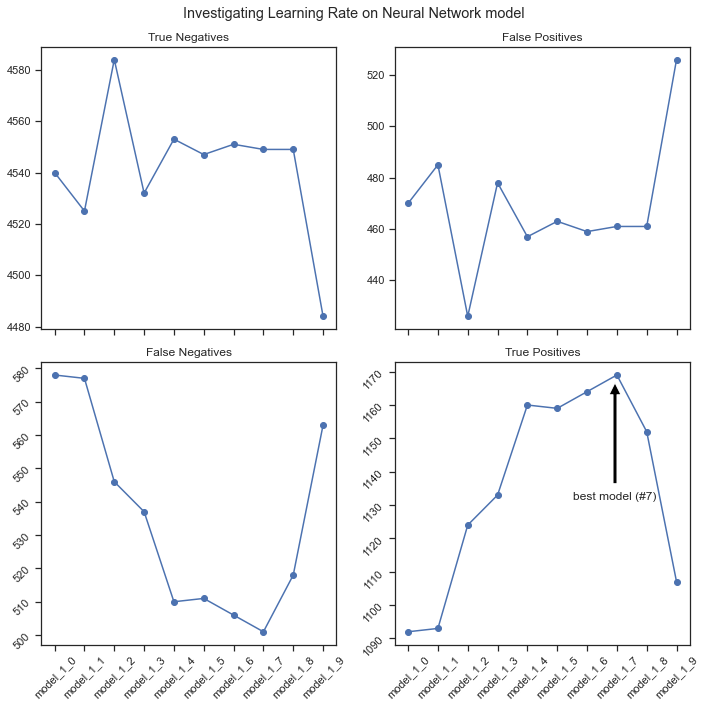

In [87]:
sns.set_theme(style='ticks')

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, sharex=True,  figsize=(10,10))  # xticks(rotation=45),

ax0.plot(summary['tn'], 'o-')
ax0.set_title('True Negatives')
ax1.plot(summary['fp'], 'o-')
ax1.set_title('False Positives')
ax2.plot(summary['fn'], 'o-')
ax2.set_title('False Negatives')
ax3.plot(summary['tp'], 'o-')
ax3.set_title('True Positives')
fig.suptitle('Investigating Learning Rate on Neural Network model')
ax3.annotate('best model (#7)',
            xy=(615, 330), xycoords='figure points',
            xytext=(0, -125), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='center', verticalalignment='bottom')
ax2.tick_params(labelrotation=45)
ax3.tick_params(labelrotation=45)
plt.tight_layout()
plt.savefig("./images/LR_h-paramater_tp-tn-fp-fn.png")
plt.show()

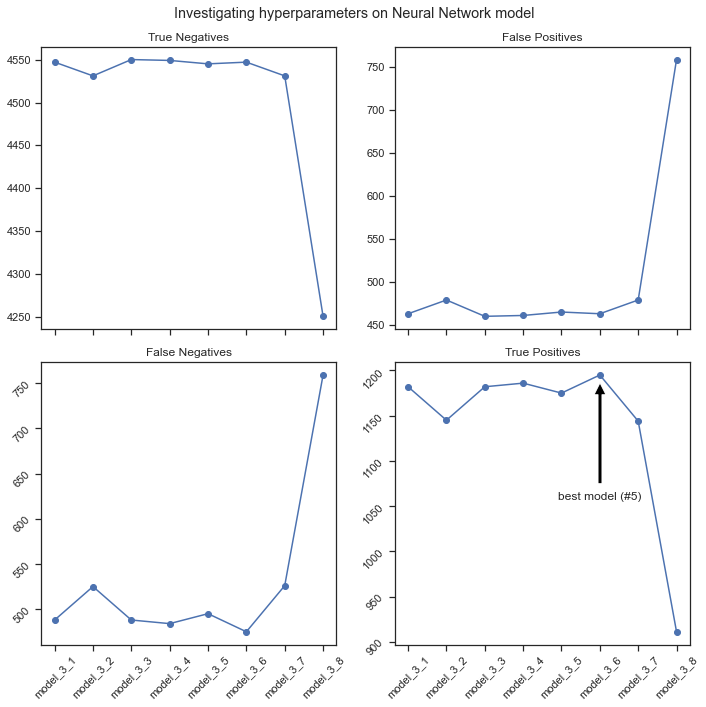

In [159]:
sns.set_theme(style='ticks')

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, sharex=True,  figsize=(10,10))  # xticks(rotation=45),

ax0.plot(summary['tn'], 'o-')
ax0.set_title('True Negatives')
ax1.plot(summary['fp'], 'o-')
ax1.set_title('False Positives')
ax2.plot(summary['fn'], 'o-')
ax2.set_title('False Negatives')
ax3.plot(summary['tp'], 'o-')
ax3.set_title('True Positives')
fig.suptitle('Investigating hyperparameters on Neural Network model')
ax3.annotate('best model (#5)',
            xy=(600, 330), xycoords='figure points',
            xytext=(0, -125), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='center', verticalalignment='bottom')
ax2.tick_params(labelrotation=45)
ax3.tick_params(labelrotation=45)
plt.tight_layout()
plt.savefig("./images/NNx_h-paramater_tp-tn-fp-fn.png")
plt.show()

In [ ]:
history_1_1 = model_1_1.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=50, verbose=0)  # class_weight=?
history_1_2 = model_1_2.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=50, verbose=0)  # class_weight=?
history_1_3 = model_1_3.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=50, verbose=0)  # class_weight=?
history_1_4 = model_1_4.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=50, verbose=0)  # class_weight=?

history_2_1 = model_2_1.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=50, verbose=0)
history_2_2 = model_2_2.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=50, verbose=0)
history_2_3 = model_2_3.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=50, verbose=0)
history_2_4 = model_2_4.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=50, verbose=0)

history_3_1 = model_3_1.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=50, verbose=0)
history_3_2 = model_3_2.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=50, verbose=0)
history_3_3 = model_3_3.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=50, verbose=0)
history_3_4 = model_3_4.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=50, verbose=0)

history_1_5 = model_1_5.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=50, verbose=0)  # class_weight=?
history_1_6 = model_1_6.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=50, verbose=0)  # class_weight=?
history_1_7 = model_1_7.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=50, verbose=0)  # class_weight=?
history_1_8 = model_1_8.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=50, verbose=0)  # class_weight=?

history_2_5 = model_2_5.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=50, verbose=0)
history_2_6 = model_2_6.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=50, verbose=0)
history_2_7 = model_2_7.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=50, verbose=0)
history_2_8 = model_2_8.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=50, verbose=0)

history_3_5 = model_3_5.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=50, verbose=0)
history_3_6 = model_3_6.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=50, verbose=0)
history_3_7 = model_3_7.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=50, verbose=0)
history_3_8 = model_3_8.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=50, verbose=0)

In [170]:
# best
#model_1_1 = build_model(n_hidden=1, n_neurons=64, learning_rate=5e-4, input_shape=None)
#model_1_1 = build_model(n_hidden=4, n_neurons=64, learning_rate=1e-3, input_shape=None)
# {'learning_rate': 0.0006713362563809696, 'n_hidden': 4, 'n_neurons': 56}

# #============
# summary_dict = {}

# for i in range(len(models)):
#     models[i].fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, verbose=0)
#     loss, tp, fp, tn, fn, accuracy, precision, recall, auc, prc, *validations = models[i].evaluate(X_test, y_test)
#     summary_dict[model_names[i]] = [loss, tp, fp, tn, fn, accuracy, precision, recall, auc, prc, model_names[i]]
    

# summary=pd.DataFrame(summary_dict).transpose();
# col_names={0:"loss", 1:"tp", 2:"fp", 3:"tn", 4:"fn", 5:"accuracy", 6:"precision", 7:"recall", 8:"auc", 9:"prcurve", 10:"model"}
# summary.rename(columns = col_names, inplace=True)
#============

ten_times = {}

#model = build_model(n_hidden=4, n_neurons=56, learning_rate=7e-4, input_shape=None) # model_3_1
#model = build_model(n_hidden=2, n_neurons=16, learning_rate=8e-4, input_shape=None) # model_2_2
#model = build_model(n_hidden=2, n_neurons=40, learning_rate=2e-4, input_shape=None)  # ** 3_5
model = build_model(n_hidden=2, n_neurons=40, learning_rate=2e-2, input_shape=None)  # ** _3_5
for i in range(10):    
    model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20, verbose=0)
    loss, tp, fp, tn, fn, accuracy, precision, recall, auc, prc, *validations = model.evaluate(X_train, y_train)
    ten_times[i] = [loss, tp, fp, tn, fn, accuracy, precision, recall, auc, prc]
    

63/63 [==============================] - 0s 3ms/step - loss: 0.6121 - tp: 1448.0000 - fp: 538.0000 - tn: 5474.0000 - fn: 556.0000 - accuracy: 0.7265 - precision: 0.7291 - recall: 0.7226 - auc: 0.9283 - prc: 0.7980


In [161]:
ten_runs = pd.DataFrame(ten_times).transpose()
ten_runs.rename(columns=col_names, inplace=True)

In [162]:
ten_runs

,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prcurve
0,0.625513,1451.0,546.0,5466.0,553.0,0.726048,0.726590,0.724052,0.926076,0.791350
1,0.615329,1428.0,543.0,5469.0,576.0,0.721058,0.724505,0.712575,0.927144,0.794843
2,0.607414,1459.0,523.0,5489.0,545.0,0.734032,0.736125,0.728044,0.929246,0.798444
3,0.610035,1457.0,524.0,5488.0,547.0,0.732535,0.735487,0.727046,0.928681,0.796012
4,0.604066,1448.0,527.0,5485.0,556.0,0.730539,0.733165,0.722555,0.930315,0.800897
5,0.597573,1459.0,523.0,5489.0,545.0,0.732535,0.736125,0.728044,0.931089,0.801863
6,0.610115,1457.0,523.0,5489.0,547.0,0.732036,0.735859,0.727046,0.928413,0.794782
7,0.598350,1462.0,524.0,5488.0,542.0,0.732535,0.736153,0.729541,0.931061,0.804232
8,0.622409,1432.0,545.0,5467.0,572.0,0.722555,0.724330,0.714571,0.925454,0.788334
9,0.601369,1448.0,525.0,5487.0,556.0,0.729541,0.733908,0.722555,0.930448,0.802838


In [163]:
ten_runs.describe()

,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prcurve
count,10.000000,10.000000,10.00000,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.609217,1450.100000,530.30000,5481.70000,553.900000,0.729341,0.732225,0.723603,0.928793,0.797360
std,0.009565,11.647126,10.01166,10.01166,11.647126,0.004556,0.005023,0.005812,0.002030,0.005202
min,0.597573,1428.000000,523.00000,5466.00000,542.000000,0.721058,0.724330,0.712575,0.925454,0.788334
25%,0.602044,1448.000000,523.25000,5473.00000,545.500000,0.726921,0.728234,0.722555,0.927461,0.794798
50%,0.608724,1454.000000,524.50000,5487.50000,550.000000,0.731287,0.734697,0.725549,0.928963,0.797228
75%,0.614026,1458.500000,539.00000,5488.75000,556.000000,0.732535,0.736058,0.727794,0.930415,0.801622
max,0.625513,1462.000000,546.00000,5489.00000,576.000000,0.734032,0.736153,0.729541,0.931089,0.804232


In [164]:
#print(model.predict(X_test))
y_predict = np.argmax(model.predict(X_test), axis=1)+1

In [165]:
y_test_array = np.argmax(np.array(y_test), axis=1)+1

In [166]:
y_test_array

array([3, 3, 2, ..., 1, 2, 2], dtype=int64)

In [167]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test_array, y_predict))

[[ 30  46   0   0]
 [  3 345 138   1]
 [  0 116 728  67]
 [  0   2 101  93]]


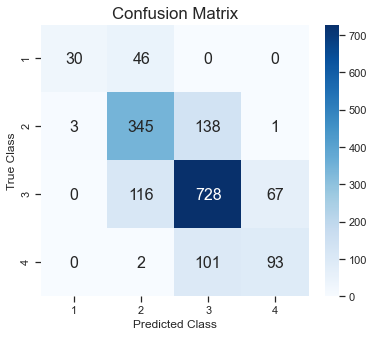

In [168]:
import seaborn as sns
def confusion_plot(y, y_pred):
    matrix = confusion_matrix(y, y_pred)
    #print(matrix)
    row_names = ['1', '2', '3', '4']
    col_names = ['1', '2', '3', '4']
    df_confusion = pd.DataFrame(matrix, index=row_names, columns=col_names)
    #print(df_confusion)
    plt.figure(figsize = (6,5))
    sns.heatmap(df_confusion, annot=True,  cmap="Blues", fmt=".0f", annot_kws={"size": 16})    
    sns.set(font_scale=1.4)#for label size  
    plt.ylim([0,4])
    plt.gca().invert_yaxis()
    plt.title("Confusion Matrix")
    plt.ylabel("True Class")
    plt.xlabel("Predicted Class")
    plt.savefig('./images/confusion_matrix.png')
    plt.show()
    plt.close()
    
confusion_plot(y_test_array, y_predict)

In [169]:
confusion = confusion_matrix(y_test_array, y_predict)
print('Confusion Matrix\n')
print(confusion)

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test_array, y_predict)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test_array, y_predict, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test_array, y_predict, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test_array, y_predict, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test_array, y_predict, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test_array, y_predict, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test_array, y_predict, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test_array, y_predict, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test_array, y_predict, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test_array, y_predict, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test_array, y_predict, target_names=['Class 1', 'Class 2', 'Class 3', 'Class 4']))

Confusion Matrix

[[ 30  46   0   0]
 [  3 345 138   1]
 [  0 116 728  67]
 [  0   2 101  93]]

Accuracy: 0.72

Micro Precision: 0.72
Micro Recall: 0.72
Micro F1-score: 0.72

Macro Precision: 0.73
Macro Recall: 0.59
Macro F1-score: 0.63

Weighted Precision: 0.72
Weighted Recall: 0.72
Weighted F1-score: 0.71

Classification Report

              precision    recall  f1-score   support

     Class 1       0.91      0.39      0.55        76
     Class 2       0.68      0.71      0.69       487
     Class 3       0.75      0.80      0.78       911
     Class 4       0.58      0.47      0.52       196

    accuracy                           0.72      1670
   macro avg       0.73      0.59      0.63      1670
weighted avg       0.72      0.72      0.71      1670



In [ ]:
# # Plot history
# # set metrics=['accuracy']
# pd.DataFrame(history.history).plot(figsize=(8, 5))

# plt.grid(True)
# plt.gca().set_ylim(0, 1)
# plt.gca().set_xlim(0, len(history.epoch))
# plt.legend()
# plt.show()

# save_model(model, "best_params.h5")
# #old_model = load_model("testing.h5")
# #print(old_model.summary())

In [ ]:
df_1_1 = pd.DataFrame(history_1_1.history)
df_1_2 = pd.DataFrame(history_1_2.history)
df_1_3 = pd.DataFrame(history_1_3.history)
df_1_4 = pd.DataFrame(history_1_4.history)
df_2_1 = pd.DataFrame(history_2_1.history)
df_2_2 = pd.DataFrame(history_2_2.history)
df_2_3 = pd.DataFrame(history_2_3.history)
df_2_4 = pd.DataFrame(history_2_4.history)
df_3_1 = pd.DataFrame(history_3_1.history)
df_3_2 = pd.DataFrame(history_3_2.history)
df_3_3 = pd.DataFrame(history_3_3.history)
df_3_4 = pd.DataFrame(history_3_4.history)

df_1_5 = pd.DataFrame(history_1_5.history)
df_1_6 = pd.DataFrame(history_1_6.history)
df_1_7 = pd.DataFrame(history_1_7.history)
df_1_8 = pd.DataFrame(history_1_8.history)
df_2_5 = pd.DataFrame(history_2_5.history)
df_2_6 = pd.DataFrame(history_2_6.history)
df_2_7 = pd.DataFrame(history_2_7.history)
df_2_8 = pd.DataFrame(history_2_8.history)
df_3_5 = pd.DataFrame(history_3_5.history)
df_3_6 = pd.DataFrame(history_3_6.history)
df_3_7 = pd.DataFrame(history_3_7.history)
df_3_8 = pd.DataFrame(history_3_8.history)

df_1_1['model'] = 11
df_1_2['model'] = 12
df_1_3['model'] = 13
df_1_4['model'] = 14
df_2_1['model'] = 21
df_2_2['model'] = 22
df_2_3['model'] = 23
df_2_4['model'] = 24
df_3_1['model'] = 31
df_3_2['model'] = 32
df_3_3['model'] = 33
df_3_4['model'] = 34

df_1_5['model'] = 15
df_1_6['model'] = 16
df_1_7['model'] = 17
df_1_8['model'] = 18
df_2_5['model'] = 25
df_2_6['model'] = 26
df_2_7['model'] = 27
df_2_8['model'] = 28
df_3_5['model'] = 35
df_3_6['model'] = 36
df_3_7['model'] = 37
df_3_8['model'] = 38

df_models = pd.concat([df_1_1, df_1_2, df_1_3, df_1_4, df_1_5, df_1_6, df_1_7, df_1_8,
                       df_2_1, df_2_2, df_2_3, df_2_4, df_2_5, df_2_6, df_2_7, df_2_8,
                       df_3_1, df_3_2, df_3_3, df_3_4, df_3_5, df_3_6, df_3_7, df_3_8,
                      ])

In [ ]:
df_models['accuracy'].max()

In [ ]:
df_1_1['accuracy'].plot(figsize=(8, 5))
df_1_2['accuracy'].plot()
df_1_3['accuracy'].plot()
df_1_4['accuracy'].plot()

plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.gca().set_xlim(0, len(history_1_1.epoch))
plt.legend()
plt.show()